In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LR


import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
df = pd.read_csv("Customer360Insights.csv")

In [3]:
df.head()

,SessionStart,CustomerID,FullName,Gender,Age,CreditScore,MonthlyIncome,Country,State,City,...,Price,Quantity,CampaignSchema,CartAdditionTime,OrderConfirmation,OrderConfirmationTime,PaymentMethod,SessionEnd,OrderReturn,ReturnReason
0,2019-01-01 02:42:00,1001,Brittany Franklin,Male,57,780,7591,China,Guangdong,Dongguan,...,50,4,Instagram-ads,2019-01-01 02:49:00,True,2019-01-01 03:02:00,Cash On Delivery,2019-01-01 02:53:00,False,NaN
1,2019-01-02 20:35:00,1002,Scott Stewart,Female,69,746,3912,China,Shandong,Yantai,...,80,6,Google-ads,2019-01-02 20:50:00,True,2019-01-02 20:58:00,Debit Card,2019-01-02 20:54:00,False,NaN
2,2019-01-04 03:11:00,1003,Elizabeth Fowler,Female,21,772,7460,UK,England,Birmingham,...,20,2,Facebook-ads,2019-01-04 03:30:00,True,2019-01-04 03:40:00,Cash On Delivery,2019-01-04 03:35:00,False,NaN
3,2019-01-05 09:01:00,1004,Julian Wall,Female,67,631,4765,UK,England,Birmingham,...,20,2,Twitter-ads,2019-01-05 09:17:00,True,2019-01-05 09:26:00,Cash On Delivery,2019-01-05 09:20:00,False,NaN
4,2019-01-05 13:35:00,1005,James Simmons,Male,57,630,3268,China,Shandong,Yantai,...,100,6,Billboard-QR code,2019-01-05 13:40:00,True,2019-01-05 13:52:00,Debit Card,2019-01-05 13:42:00,False,NaN


In [4]:
df.columns

Index(['SessionStart', 'CustomerID', 'FullName', 'Gender', 'Age',
       'CreditScore', 'MonthlyIncome', 'Country', 'State', 'City', 'Category',
       'Product', 'Cost', 'Price', 'Quantity', 'CampaignSchema ',
       'CartAdditionTime', 'OrderConfirmation', 'OrderConfirmationTime',
       'PaymentMethod', 'SessionEnd', 'OrderReturn', 'ReturnReason'],
      dtype='object')

In [5]:
# Removing irrelevant columns and keeping demographics/credit score
df = df.drop(['SessionStart', 'CustomerID', 'FullName', 'State', 'City','Category',
       'Product', 'Cost', 'Price', 'Quantity', 'CartAdditionTime','OrderConfirmationTime',
       'PaymentMethod', 'SessionEnd', 'OrderReturn', 'ReturnReason'], axis= 1)

In [6]:
df.head()

,Gender,Age,CreditScore,MonthlyIncome,Country,CampaignSchema,OrderConfirmation
0,Male,57,780,7591,China,Instagram-ads,True
1,Female,69,746,3912,China,Google-ads,True
2,Female,21,772,7460,UK,Facebook-ads,True
3,Female,67,631,4765,UK,Twitter-ads,True
4,Male,57,630,3268,China,Billboard-QR code,True


In [7]:
# Labeling categorical data for training the model
label = preprocessing.LabelEncoder()
df_labeled = df
n = 0

# Printing the labels assigned to each category for future reference
for i in df.drop(['Age', 'CreditScore', 'MonthlyIncome'], axis=1):
    df_labeled[i] = label.fit_transform(df_labeled[i].astype('str'))
    mapping = {l: x for x, l in enumerate(label.classes_)}
    print(mapping)

{'Female': 0, 'Male': 1}
{'Australia': 0, 'Canada': 1, 'China': 2, 'India': 3, 'Italy': 4, 'Japan': 5, 'Spain': 6, 'UK': 7, 'USA': 8}
{'Billboard-QR code': 0, 'E-mails': 1, 'Facebook-ads': 2, 'Google-ads': 3, 'Instagram-ads': 4, 'Twitter-ads': 5}
{'False': 0, 'True': 1}


In [8]:
# Dataset heavily imbalanced. We will use oversampling to balance the dataset and increase the minority samples.
df_labeled['OrderConfirmation'].value_counts()

1    1700
0     300
Name: OrderConfirmation, dtype: int64

In [49]:
# In certain classification problems, the correlation between features is minimal, which is the phenomenon of multicollinearity. 
# To find the correlated values (most important ones), we employ VIF ()
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_func(x):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

    return(vif)

In [58]:
vif_df = df.drop(['OrderConfirmation'], axis=1)

# Normalize first to fix high VIF values
scaler = MinMaxScaler()
vif_df_scaled = scaler.fit_transform(vif_df)
vif_df_scaled = pd.DataFrame(vif_df_scaled, columns = vif_df.columns)

vif_func(vif_df_scaled)

# With Multicollinearity fixed, the VIF score

,variables,VIF
0,Gender,1.873543
1,Age,2.929296
2,CreditScore,3.408604
3,MonthlyIncome,3.401268
4,Country,2.783711
5,CampaignSchema,2.827747


In [9]:
# Splitting into features X and target y variable
X = df_labeled.drop(['OrderConfirmation'], axis= 1)
y = df_labeled['OrderConfirmation']

In [10]:
# 80% of dataset to train, 20% of dataset for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [11]:
y_train.value_counts()

1    1360
0     240
Name: OrderConfirmation, dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [90]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = {0: 900})
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

In [91]:
y_train_smote.value_counts()

1    1360
0     900
Name: OrderConfirmation, dtype: int64

In [92]:
# Logistic Regression 

# Resampled
model_res = LR(max_iter=100)

model_res.fit(X_train_smote, y_train_smote)
res_pred = model_res.predict(X_test_scaled)

Accuracy on testing set: 0.84
              precision    recall  f1-score   support

           0       0.30      0.05      0.09        60
           1       0.85      0.98      0.91       340

    accuracy                           0.84       400
   macro avg       0.58      0.51      0.50       400
weighted avg       0.77      0.84      0.79       400



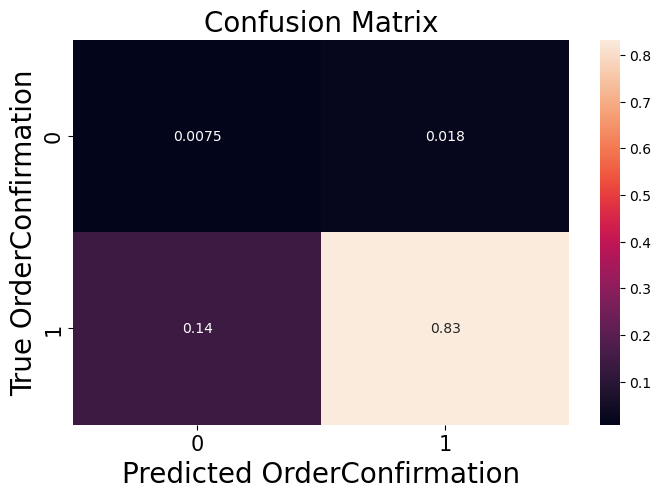

In [93]:
matrix = confusion_matrix(res_pred, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted OrderConfirmation', size=20)
ax.set_ylabel('True OrderConfirmation', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(res_pred, y_test))
print(classification_report(y_test, res_pred))

In [94]:
res_probabilities = model_res.predict_proba(X_test_scaled)
res_probabilities = pd.DataFrame(res_probabilities, columns = ['Probability 0', 'Probability 1'])
res_probabilities[res_probabilities['Probability 0'] < 0.3].count()

Probability 0    10
Probability 1    10
dtype: int64

In [45]:
# Logistic Regression
model = LR(max_iter=100)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

Accuracy on testing set: 0.85
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.85      1.00      0.92       340

    accuracy                           0.85       400
   macro avg       0.42      0.50      0.46       400
weighted avg       0.72      0.85      0.78       400



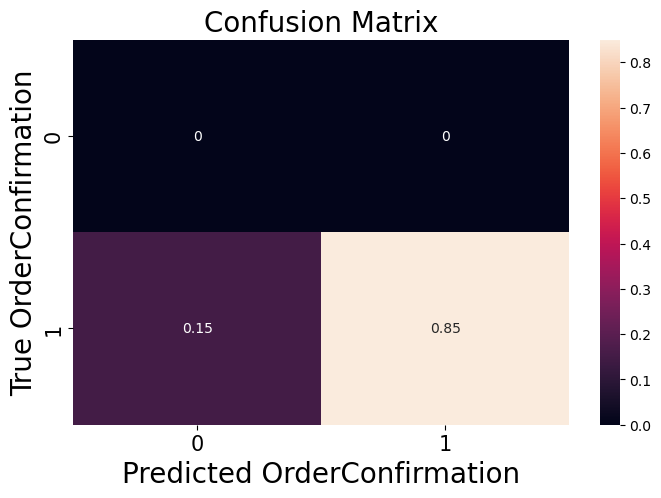

In [46]:
matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted OrderConfirmation', size=20)
ax.set_ylabel('True OrderConfirmation', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

In [54]:
probabilities = model_res.predict_proba(X_test_scaled)
probabilities

array([[0.41445683, 0.58554317],
       [0.34408345, 0.65591655],
       [0.4583461 , 0.5416539 ],
       [0.30791639, 0.69208361],
       [0.37149776, 0.62850224],
       [0.35734115, 0.64265885],
       [0.48480343, 0.51519657],
       [0.38918316, 0.61081684],
       [0.38379812, 0.61620188],
       [0.40200072, 0.59799928],
       [0.43285614, 0.56714386],
       [0.37751987, 0.62248013],
       [0.43390138, 0.56609862],
       [0.36846888, 0.63153112],
       [0.44288572, 0.55711428],
       [0.38816116, 0.61183884],
       [0.43552661, 0.56447339],
       [0.41733815, 0.58266185],
       [0.44716966, 0.55283034],
       [0.45111929, 0.54888071],
       [0.39266661, 0.60733339],
       [0.32965185, 0.67034815],
       [0.41005758, 0.58994242],
       [0.40639569, 0.59360431],
       [0.36501601, 0.63498399],
       [0.39092007, 0.60907993],
       [0.43412817, 0.56587183],
       [0.39131939, 0.60868061],
       [0.3194903 , 0.6805097 ],
       [0.3988836 , 0.6011164 ],
       [0.

In [16]:
# Support Vector Machines
from sklearn.ensemble import RandomForestClassifier
dtc = RandomForestClassifier()

dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)               

In [15]:
# writing model output file

df_prediction_prob = pd.DataFrame(predictions, columns = ['Will', 'prob_1'])
df_test_dataset = pd.DataFrame(y_test,columns= ['Actual Outcome'])
df_x_test = pd.DataFrame(X_test)

dfx=pd.concat([df_x_test,df_test_dataset, df_prediction_prob], axis=1)

dfx.to_excel("c1_ModelOutput_10Percent.xlsx")

dfx.head()

NameError: name 'predictions' is not defined

Accuracy on testing set: 0.825
              precision    recall  f1-score   support

           0       0.19      0.05      0.08        60
           1       0.85      0.96      0.90       340

    accuracy                           0.82       400
   macro avg       0.52      0.51      0.49       400
weighted avg       0.75      0.82      0.78       400



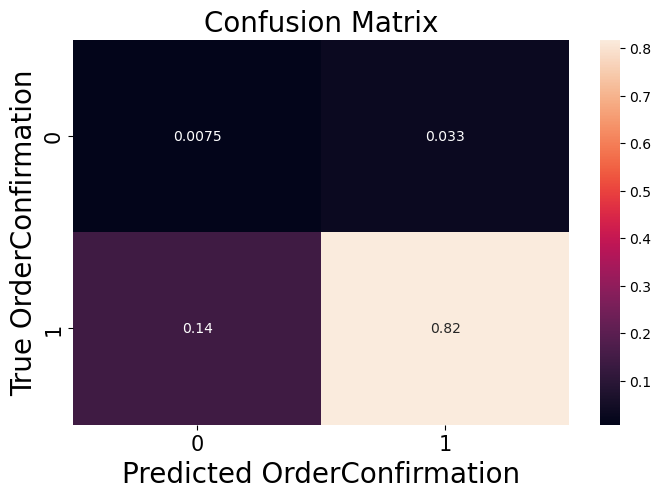

In [18]:
matrix_dtc = confusion_matrix(y_pred_dtc, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix_dtc, annot=True, ax = ax)

ax.set_xlabel('Predicted OrderConfirmation', size=20)
ax.set_ylabel('True OrderConfirmation', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(y_pred_dtc, y_test))
print(classification_report(y_test, y_pred_dtc))

In [17]:
# There is a slightly better score on LogisticRegressor, but it largely missclassifies OrderConfirmation = 0
# We pick RandomForestClassifier, as it appears less biased from the confusion matrix.

In [21]:

model3 = LR(max_iter=500)

model3.fit(X_train, y_train)
nb = model3.predict(X_test)

Accuracy on testing set: 0.85


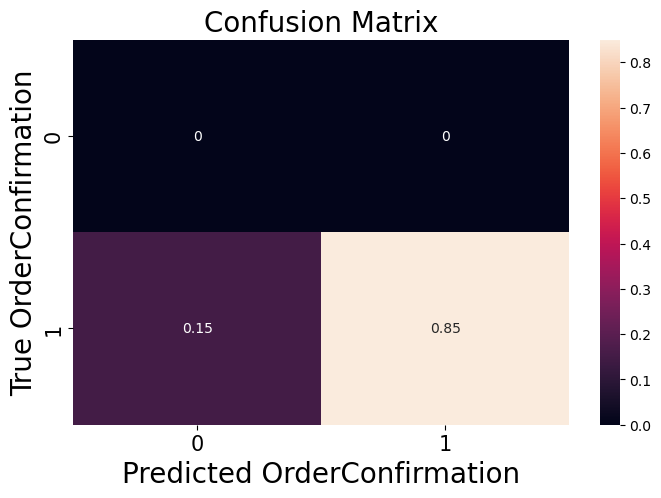

In [22]:
matrix = confusion_matrix(nb, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted OrderConfirmation', size=20)
ax.set_ylabel('True OrderConfirmation', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(nb, y_test))

In [20]:
probabilities = model3.predict_proba(X_test)
probabilities

array([[0.16938584, 0.83061416],
       [0.12973928, 0.87026072],
       [0.15361548, 0.84638452],
       [0.15190953, 0.84809047],
       [0.16962083, 0.83037917],
       [0.13220101, 0.86779899],
       [0.20248528, 0.79751472],
       [0.14855933, 0.85144067],
       [0.13900666, 0.86099334],
       [0.10740508, 0.89259492],
       [0.17018012, 0.82981988],
       [0.11791234, 0.88208766],
       [0.12615311, 0.87384689],
       [0.1686288 , 0.8313712 ],
       [0.10915692, 0.89084308],
       [0.13644056, 0.86355944],
       [0.14208186, 0.85791814],
       [0.15631664, 0.84368336],
       [0.22055833, 0.77944167],
       [0.17926989, 0.82073011],
       [0.16407736, 0.83592264],
       [0.13402001, 0.86597999],
       [0.15280578, 0.84719422],
       [0.14878657, 0.85121343],
       [0.17706581, 0.82293419],
       [0.13535531, 0.86464469],
       [0.16118249, 0.83881751],
       [0.17374983, 0.82625017],
       [0.18176337, 0.81823663],
       [0.14906689, 0.85093311],
       [0.